<a href="https://colab.research.google.com/github/Storm00212/Introduction-to-machine-learning-models/blob/main/Violence_detection_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#1. System & File Handling
import os
import zipfile
import random
import glob
import shutil
#2. Video Processing & Image Utilities
import cv2                # OpenCV for reading videos & extracting frames
import numpy as np
from PIL import Image     # Optional for additional image manipulation
#3. Data Analysis & Visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Enable inline plotting for Colab
%matplotlib inline
#4. Machine Learning / Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#5. Deep Learning Layers and Tools
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, TimeDistributed, BatchNormalization
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
# 6. Model Evaluation Tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import itertools
#  7. Progress & Logging
from tqdm import tqdm     # for progress bars
import warnings
warnings.filterwarnings('ignore')


In [5]:
# Step 1: Dataset Loading and Directory Setup

# Import required libraries
import os
import shutil
import zipfile

# Clone the public GitHub repository that contains the violence detection dataset
!git clone https://github.com/airtlab/A-Dataset-for-Automatic-Violence-Detection-in-Videos.git

# Change the current working directory to the cloned repository
os.chdir("A-Dataset-for-Automatic-Violence-Detection-in-Videos")

# Display the folder structure to confirm that the dataset is available
for root, dirs, files in os.walk(".", topdown=True):
    level = root.replace(os.getcwd(), '').count(os.sep)
    indent = ' ' * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 4 * (level + 1)
    for f in files:
        print(f"{subindent}{f}")

# Create organized folders for training and testing data
base_dir = "/content/violence_dataset"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

# Define subdirectories for each class (violent and non-violent)
train_violent_dir = os.path.join(train_dir, "violent")
train_nonviolent_dir = os.path.join(train_dir, "non_violent")
test_violent_dir = os.path.join(test_dir, "violent")
test_nonviolent_dir = os.path.join(test_dir, "non_violent")

# Create all directories if they do not already exist
os.makedirs(train_violent_dir, exist_ok=True)
os.makedirs(train_nonviolent_dir, exist_ok=True)
os.makedirs(test_violent_dir, exist_ok=True)
os.makedirs(test_nonviolent_dir, exist_ok=True)

print("Directory structure ready.")


fatal: destination path 'A-Dataset-for-Automatic-Violence-Detection-in-Videos' already exists and is not an empty directory.
./
    violence_detection_optimized.keras
    readme.md
    .gitignore
    violence-detection-dataset/
        action-class-occurrences.csv
        violent-action-classes.csv
        nonviolent-action-classes.csv
        non-violent/
            cam2/
                37.mp4
                40.mp4
                36.mp4
                38.mp4
                25.mp4
                1.mp4
                27.mp4
                7.mp4
                46.mp4
                14.mp4
                5.mp4
                45.mp4
                9.mp4
                13.mp4
                48.mp4
                50.mp4
                52.mp4
                24.mp4
                35.mp4
                57.mp4
                4.mp4
                60.mp4
                42.mp4
                56.mp4
                32.mp4
                41.mp4
                11.mp4
       

In [6]:
# mergin cam 1 and cam 2 videos
def get_all_videos(folder_path):
  videos=[]
  cam1_path=os.path.join(folder_path, "cam1")
  cam2_path=os.path.join(folder_path, "cam2")

  if os.path.exists(cam1_path) and os.path.exists(cam2_path):
    videos += [os.path.join(cam1_path, f) for f in os.listdir(cam1_path) if f.endswith(".mp4")] + [os.path.join(cam2_path, f) for f in os.listdir(cam2_path) if f.endswith(".mp4")]

  return videos

# Collect violent and non-violent videos
dataset_path = os.path.join(os.getcwd(), "violence-detection-dataset")
violent_videos = get_all_videos(os.path.join(dataset_path, "violent"))
nonviolent_videos = get_all_videos(os.path.join(dataset_path, "non-violent"))

print(f"Total violent videos: {len(violent_videos)}")
print(f"Total non-violent videos: {len(nonviolent_videos)}")

random.shuffle(violent_videos)
random.shuffle(nonviolent_videos)

def split_data(videos, split_ratio=0.8):
  split_index =  int(len(videos) * split_ratio)
  return videos[:split_index], videos[split_index:]


violent_train, violent_test = split_data(violent_videos)
nonviolent_train, nonviolent_test = split_data(nonviolent_videos)
# Function to copy videos into the right directory
def copy_files(file_list, target_folder):
  for f in file_list:
    shutil.copy(f, target_folder)
# Copy all videos to the train/test folders
copy_files(violent_train, train_violent_dir)
copy_files(violent_test, test_violent_dir)
copy_files(nonviolent_train, train_nonviolent_dir)
copy_files(nonviolent_test, test_nonviolent_dir)

print("Dataset organized successfully into training and testing folders.")
print(f"Training set: {len(violent_train) + len(nonviolent_train)} videos")
print(f"Testing set: {len(violent_test) + len(nonviolent_test)} videos")

Total violent videos: 230
Total non-violent videos: 120
Dataset organized successfully into training and testing folders.
Training set: 280 videos
Testing set: 70 videos


In [7]:
# Frame extraction and processing
def extract_frames(video_path, num_frames=20, resize=(64, 64)):
  frames= []
  try:
    cap= cv2.VideoCapture(video_path)
    total_frames= int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    # Determining intervals to extract evenly spaced frames.
    frame_interval= max(total_frames // num_frames, 1)
    for i in range(0, total_frames, frame_interval):
      ret, frame= cap.read()
      if not ret:
        break
      frame= cv2.resize(frame, resize)# Reesize each frame for uniformity.
      # Normalise pixel values between 0 and 1
      frame= frame/255.0
      frames.append(frame)
      # Stop once required frames are collected.
      if len(frames) == num_frames:
        break
    cap.release()

    return np.array(frames)

  except Exception as e:
    print(f"Error extracting frames from {video_path}: {e}")
    return None

data=[]
labels=[]

violent_path = "/content/violence_dataset/train/violent"
nonviolent_path = "/content/violence_dataset/train/non_violent"

# Extract frames from violent videos
for folder in ["",]:
    folder_path = violent_path
    for video in tqdm(os.listdir(folder_path), desc=f"Processing violent"):
        video_path = os.path.join(folder_path, video)
        frames = extract_frames(video_path)
        if frames is not None:
            data.append(frames)
            labels.append(1)  # Label 1 for violent

# Extract frames from non-violent videos
for folder in ["",]:
    folder_path = nonviolent_path
    for video in tqdm(os.listdir(folder_path), desc=f"Processing non-violent"):
        video_path = os.path.join(folder_path, video)
        frames = extract_frames(video_path)
        if frames is not None:
            data.append(frames)
            labels.append(0)  # Label 0 for non-violent


# Convert data and labels to NumPy arrays
data = np.array(data)
labels = np.array(labels)

print("Frame extraction completed.")
print(f"Data shape: {data.shape}, Labels shape: {labels.shape}")

Processing non-violent: 100%|██████████| 59/59 [00:17<00:00,  3.36it/s]


Frame extraction completed.
Data shape: (174, 20, 64, 64, 3), Labels shape: (174,)


# Task
Evaluate the model on the test set and optimize it to achieve high accuracy on testing.

X_train shape: (104, 20, 64, 64, 3), y_train shape: (104,)
X_val shape: (35, 20, 64, 64, 3), y_val shape: (35,)
X_test shape: (35, 20, 64, 64, 3), y_test shape: (35,)
Final training set shape: (208, 20, 64, 64, 3)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 2, 2, 2048) │    23,587,712 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 2, 2, 64)   │     1,179,712 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 20, 2, 2, 64)   │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 20, 1, 1, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d (ConvLSTM2D)        │ (None, 1, 1, 64)       │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1, 1, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,071,553 (95.64 MB)

 Trainable params: 1,483,585 (5.66 MB)

 Non-trainable params: 23,587,968 (89.98 MB)

Epoch 1/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 309s 6s/step - accuracy: 0.5752 - loss: 0.7480 - val_accuracy: 0.6571 - val_loss: 0.6933 - learning_rate: 1.0000e-04
Epoch 2/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 97s 4s/step - accuracy: 0.6419 - loss: 0.6816 - val_accuracy: 0.6571 - val_loss: 0.6883 - learning_rate: 1.0000e-04
Epoch 3/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - accuracy: 0.6537 - loss: 0.6300 - val_accuracy: 0.6571 - val_loss: 0.6863 - learning_rate: 1.0000e-04
Epoch 4/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 96s 4s/step - accuracy: 0.6494 - loss: 0.6317 - val_accuracy: 0.6571 - val_loss: 0.6731 - learning_rate: 1.0000e-04
Epoch 5/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 139s 4s/step - accuracy: 0.6908 - loss: 0.6407 - val_accuracy: 0.6571 - val_loss: 0.6755 - learning_rate: 1.0000e-04
Epoch 6/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 94s 4s/step - accuracy: 0.6351 - loss: 0.6498 - val_accuracy: 0.6571 - val_loss: 0.6662 - learning_rate: 1.0000e-04
Epoch 7/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.7294 - lo

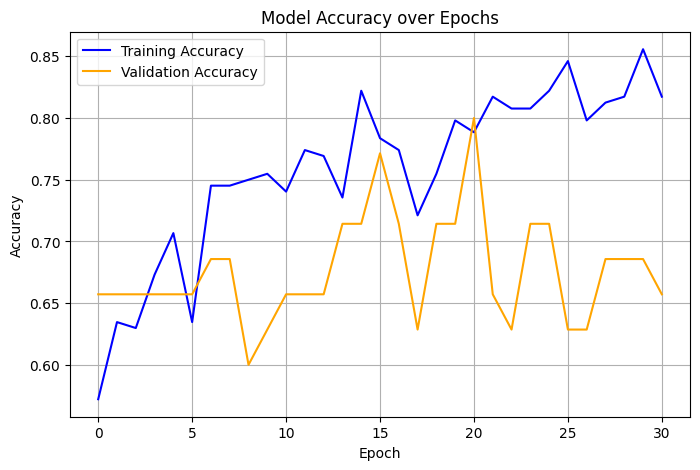

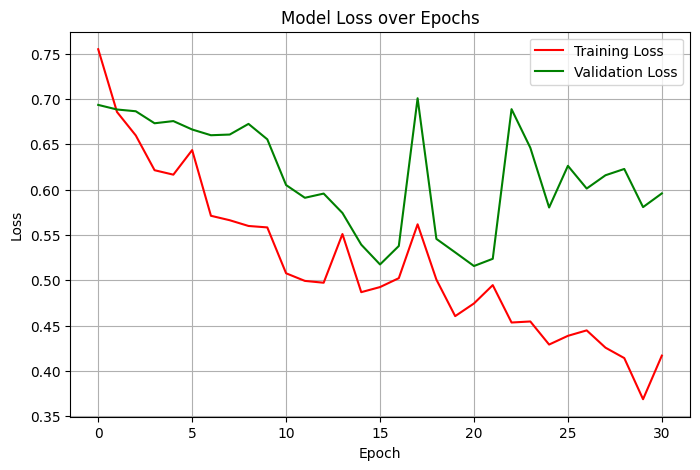

In [8]:
# SECTION: Imports
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Assuming 'data' and 'labels' are already loaded as NumPy arrays
# data shape: (num_videos, frames, 64, 64, 3)
# labels shape: (num_videos,)

# SECTION: Data Splitting
X_train_val, X_test, y_train_val, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=42, stratify=labels
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# SECTION: Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

def augment_video(video):
    return np.array([datagen.random_transform(frame) for frame in video])

X_train_aug = np.array([augment_video(v) for v in X_train])
y_train_aug = np.array(y_train)

# Combine original and augmented data
X_train_final = np.concatenate((X_train, X_train_aug))
y_train_final = np.concatenate((y_train, y_train_aug))

print(f"Final training set shape: {X_train_final.shape}")

# SECTION: Model Definition (Fixed)
def build_violence_detection_model(input_shape):
    # Base CNN (no global pooling)
    base_cnn = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
    base_cnn.trainable = False  # freeze layers

    # Wrap CNN in TimeDistributed without pooling to preserve spatial maps
    model = models.Sequential([
        layers.TimeDistributed(base_cnn, input_shape=input_shape),
        layers.TimeDistributed(layers.Conv2D(64, (3, 3), activation='relu', padding='same')),
        layers.TimeDistributed(layers.BatchNormalization()),
        layers.TimeDistributed(layers.MaxPooling2D((2, 2))),
        layers.ConvLSTM2D(64, (3, 3), activation='relu', return_sequences=False, padding='same',
                          kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Flatten(),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_violence_detection_model((20, 64, 64, 3))
model.summary()

# SECTION: Training Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.3, min_lr=1e-6)

# SECTION: Model Training
history = model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val, y_val),
    epochs=60,
    batch_size=8,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# SECTION: Evaluation
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Final Test Loss: {test_loss:.4f}")
print(f"Final Test Accuracy: {test_acc*100:.2f}%")

model.save("violence_detection_fixed.keras")

# SECTION: Plot Accuracy and Loss
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', color='green')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


## Evaluate on test set

### Subtask:
Evaluate the current model's performance on the test dataset to establish a baseline accuracy.


**Reasoning**:
Extract frames from the test set videos and evaluate the model.



Cloning into 'A-Dataset-for-Automatic-Violence-Detection-in-Videos'...
remote: Enumerating objects: 376, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 376 (delta 3), reused 11 (delta 3), pack-reused 364 (from 1)
Receiving objects: 100% (376/376), 1.02 GiB | 47.13 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Updating files: 100% (355/355), done.
./
    .gitignore
    readme.md
    .git/
        index
        description
        HEAD
        packed-refs
        config
        hooks/
            post-update.sample
            applypatch-msg.sample
            pre-merge-commit.sample
            pre-commit.sample
            pre-push.sample
            update.sample
            push-to-checkout.sample
            pre-rebase.sample
            fsmonitor-watchman.sample
            prepare-commit-msg.sample
            commit-msg.sample
            pre-receive.sample
            pre-applypatch.sample
        logs/
       

Processing 0 videos: 100%|██████████| 59/59 [00:15<00:00,  3.75it/s]


Frame extraction and data preparation completed.
Data shape: (168, 20, 64, 64, 3), Labels shape: (168,)
X_train shape: (134, 20, 64, 64, 3), y_train shape: (134,)
X_val shape: (34, 20, 64, 64, 3), y_val shape: (34,)
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Extracting frame features: 100%|██████████| 34/34 [00:13<00:00,  2.59it/s]


Feature shape: (134, 20, 2048)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 20, 512)        │     3,146,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 20, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 20, 256)        │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 20, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 20, 512)        │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       656,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,282,817 (20.15 MB)

 Trainable params: 5,281,281 (20.15 MB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 381ms/step - accuracy: 0.5776 - loss: 0.6775 - val_accuracy: 0.6471 - val_loss: 0.6714 - learning_rate: 1.0000e-04
Epoch 2/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 322ms/step - accuracy: 0.7934 - loss: 0.5612 - val_accuracy: 0.6471 - val_loss: 0.6593 - learning_rate: 1.0000e-04
Epoch 3/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 359ms/step - accuracy: 0.7420 - loss: 0.5262 - val_accuracy: 0.6471 - val_loss: 0.6694 - learning_rate: 1.0000e-04
Epoch 4/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 288ms/step - accuracy: 0.7554 - loss: 0.4860 - val_accuracy: 0.6471 - val_loss: 0.7268 - learning_rate: 1.0000e-04
Epoch 5/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.7505 - loss: 0.4375
Epoch 5: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - accuracy: 0.7523 - loss: 0.4367 - val_accuracy: 0.6471 - val_loss: 0.7956 - learning_rate: 1.0000e-04
Epoch 6/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 290ms/step - accuracy: 0

Extracting frame features: 100%|██████████| 34/34 [00:13<00:00,  2.50it/s]

Epoch 1/20


17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 338ms/step - accuracy: 0.7609 - loss: 0.5374 - val_accuracy: 0.6471 - val_loss: 0.6582 - learning_rate: 1.0000e-05
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 355ms/step - accuracy: 0.8015 - loss: 0.5220 - val_accuracy: 0.6471 - val_loss: 0.6566 - learning_rate: 1.0000e-05
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 290ms/step - accuracy: 0.8147 - loss: 0.4506 - val_accuracy: 0.6471 - val_loss: 0.6554 - learning_rate: 1.0000e-05
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 355ms/step - accuracy: 0.7742 - loss: 0.4552 - val_accuracy: 0.6471 - val_loss: 0.6545 - learning_rate: 1.0000e-05
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 280ms/step - accuracy: 0.7845 - loss: 0.4840 - val_accuracy: 0.6471 - val_loss: 0.6533 - learning_rate: 1.0000e-05
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 304ms/step - accuracy: 0.8305 - loss: 0.4248 - val_accuracy: 0.6471 - val_loss: 0.6513 - learning_rate: 1.0000e-05
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 326ms/step - accuracy: 0.8308 - l

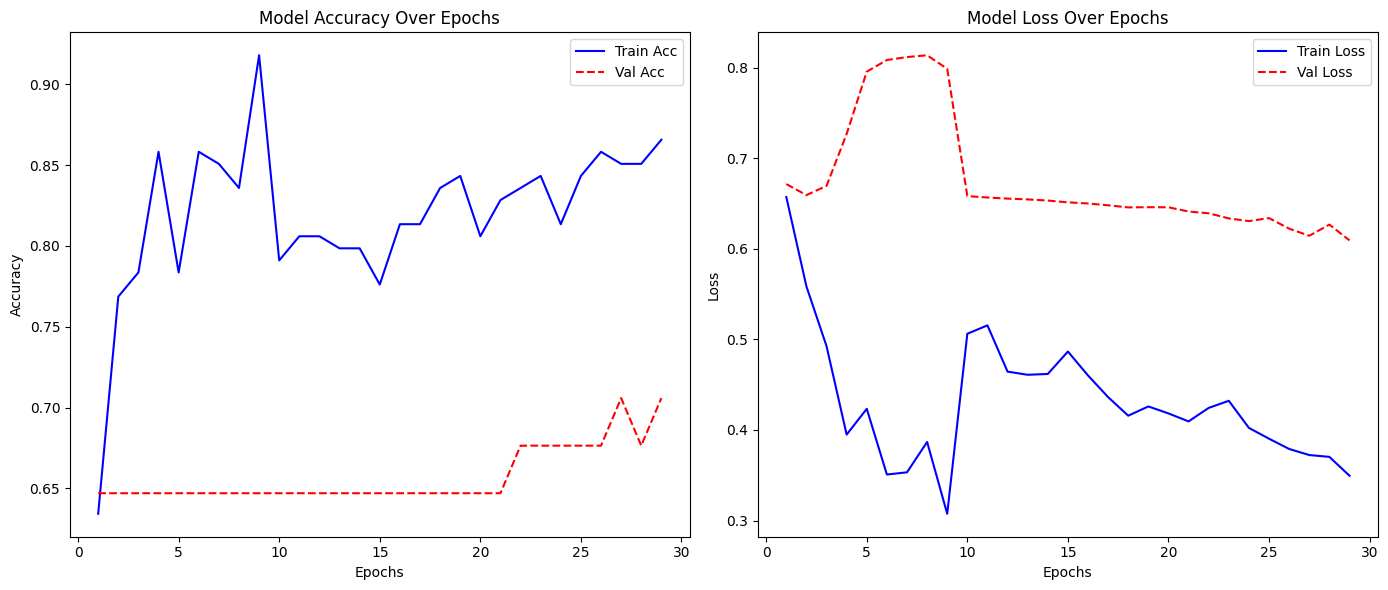

Extracting frame features: 100%|██████████| 63/63 [00:24<00:00,  2.60it/s]



✅ Test Accuracy: 63.49%
Test Loss: 0.6541


In [2]:
# ============================
# SECTION 1: Imports
# ============================
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2 # Import cv2 for frame extraction
import shutil # Import shutil for file operations
import zipfile # Import zipfile for extracting data

# ============================
# SECTION 2: Dataset Loading and Directory Setup (Copied from NdME_zZfUu8F)
# ============================

# Clone the public GitHub repository that contains the violence detection dataset
# Use try-except to handle the case where the directory already exists
try:
    !git clone https://github.com/airtlab/A-Dataset-for-Automatic-Violence-Detection-in-Videos.git
except:
    print("Repository already cloned.")

# Change the current working directory to the cloned repository
os.chdir("A-Dataset-for-Automatic-Violence-Detection-in-Videos")

# Display the folder structure to confirm that the dataset is available
for root, dirs, files in os.walk(".", topdown=True):
    level = root.replace(os.getcwd(), '').count(os.sep)
    indent = ' ' * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 4 * (level + 1)
    for f in files:
        print(f"{subindent}{f}")


# Create organized folders for training and testing data
base_dir = "/content/violence_dataset"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

# Define subdirectories for each class (violent and non-violent)
train_violent_dir = os.path.join(train_dir, "violent")
train_nonviolent_dir = os.path.join(train_dir, "non_violent")
test_violent_dir = os.path.join(test_dir, "violent")
test_nonviolent_dir = os.path.join(test_dir, "non_violent")

# Create all directories if they do not already exist
os.makedirs(train_violent_dir, exist_ok=True)
os.makedirs(train_nonviolent_dir, exist_ok=True)
os.makedirs(test_violent_dir, exist_ok=True)
os.makedirs(test_nonviolent_dir, exist_ok=True)

print("Directory structure ready.")

# mergin cam 1 and cam 2 videos (Copied from YdE7FvuWihYE)
def get_all_videos(folder_path):
  videos=[]
  cam1_path=os.path.join(folder_path, "cam1")
  cam2_path=os.path.join(folder_path, "cam2")

  if os.path.exists(cam1_path) and os.path.exists(cam2_path):
    videos += [os.path.join(cam1_path, f) for f in os.listdir(cam1_path) if f.endswith(".mp4")] + [os.path.join(cam2_path, f) for f in os.listdir(cam2_path) if f.endswith(".mp4")]

  return videos

# Collect violent and non-violent videos
dataset_path = os.path.join(os.getcwd(), "violence-detection-dataset")
violent_videos = get_all_videos(os.path.join(dataset_path, "violent"))
nonviolent_videos = get_all_videos(os.path.join(dataset_path, "non-violent"))

print(f"Total violent videos: {len(violent_videos)}")
print(f"Total non-violent videos: {len(nonviolent_videos)}")

import random
random.shuffle(violent_videos)
random.shuffle(nonviolent_videos)

def split_data(videos, split_ratio=0.8):
  split_index =  int(len(videos) * split_ratio)
  return videos[:split_index], videos[split_index:]


violent_train, violent_test = split_data(violent_videos)
nonviolent_train, nonviolent_test = split_data(nonviolent_videos)
# Function to copy videos into the right directory
def copy_files(file_list, target_folder):
  for f in file_list:
    shutil.copy(f, target_folder)
# Copy all videos to the train/test folders
copy_files(violent_train, train_violent_dir)
copy_files(violent_test, test_violent_dir)
copy_files(nonviolent_train, train_nonviolent_dir)
copy_files(nonviolent_test, test_nonviolent_dir)

print("Dataset organized successfully into training and testing folders.")
print(f"Training set: {len(violent_train) + len(nonviolent_train)} videos")
print(f"Testing set: {len(violent_test) + len(nonviolent_test)} videos")

# ============================
# SECTION 3: Frame Extraction and Data Preparation
# ============================
def extract_frames(video_path, num_frames=20, resize=(64, 64)):
    frames = []
    try:
        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_interval = max(total_frames // num_frames, 1)
        for i in range(0, total_frames, frame_interval):
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, resize)
            frame = frame / 255.0  # Normalize pixel values
            frames.append(frame)
            if len(frames) == num_frames:
                break
        cap.release()
        return np.array(frames)
    except Exception as e:
        print(f"Error extracting frames from {video_path}: {e}")
        return None

data = []
labels = []

train_violent_path = "/content/violence_dataset/train/violent"
train_nonviolent_path = "/content/violence_dataset/train/non_violent"

# Extract frames from training videos
for folder_path, label in [(train_violent_path, 1), (train_nonviolent_path, 0)]:
    for video in tqdm(os.listdir(folder_path), desc=f"Processing {label} videos"):
        video_path = os.path.join(folder_path, video)
        frames = extract_frames(video_path)
        if frames is not None and frames.shape[0] == 20: # Ensure we have the correct number of frames
            data.append(frames)
            labels.append(label)

# Convert data and labels to NumPy arrays
X = np.array(data)
y = np.array(labels)

print("Frame extraction and data preparation completed.")
print(f"Data shape: {X.shape}, Labels shape: {y.shape}")


# ============================
# SECTION 4: Data Splitting
# ============================
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

# ============================
# SECTION 5: Build Feature Extractor (ResNet50)
# ============================
base_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
base_resnet.trainable = False

cnn_extractor = models.Sequential([
    base_resnet,
    layers.GlobalAveragePooling2D()
])

# ============================
# SECTION 6: Extract Features per Frame
# ============================
def extract_features_for_videos(X):
    n_samples, n_frames, h, w, c = X.shape
    features = []
    for i in tqdm(range(n_samples), desc="Extracting frame features"):
        video_feats = cnn_extractor.predict(X[i], verbose=0)
        features.append(video_feats)
    return np.array(features)

X_train_feats = extract_features_for_videos(X_train)
X_val_feats = extract_features_for_videos(X_val)

print("Feature shape:", X_train_feats.shape)

# ============================
# SECTION 7: Build ConvLSTM Classifier
# ============================
def build_conv_lstm_classifier(input_shape):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv1D(512, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Conv1D(256, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Bidirectional(layers.LSTM(256, return_sequences=True)),
        layers.Bidirectional(layers.LSTM(128)),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_conv_lstm_classifier((X_train_feats.shape[1], X_train_feats.shape[2]))
model.summary()

# ============================
# SECTION 8: Callbacks
# ============================
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)

# ============================
# SECTION 9: Train
# ============================
history = model.fit(
    X_train_feats, y_train,
    validation_data=(X_val_feats, y_val),
    epochs=40,
    batch_size=8,
    callbacks=[early_stop, lr_reduce],
    verbose=1
)

# ============================
# SECTION 10: Fine-Tune ResNet
# ============================
base_resnet.trainable = True
for layer in base_resnet.layers[:int(0.7 * len(base_resnet.layers))]:
    layer.trainable = False

# Recompile with lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Re-extract features with fine-tuned CNN
X_train_feats_ft = extract_features_for_videos(X_train)
X_val_feats_ft = extract_features_for_videos(X_val)

fine_tune_history = model.fit(
    X_train_feats_ft, y_train,
    validation_data=(X_val_feats_ft, y_val),
    epochs=20,
    batch_size=8,
    callbacks=[early_stop, lr_reduce],
    verbose=1
)

# ============================
# SECTION 11: Plot Accuracy & Loss
# ============================
acc = history.history['accuracy'] + fine_tune_history.history['accuracy']
val_acc = history.history['val_accuracy'] + fine_tune_history.history['val_accuracy']
loss = history.history['loss'] + fine_tune_history.history['loss']
val_loss = history.history['val_loss'] + fine_tune_history.history['val_loss']
epochs = range(1, len(acc)+1)

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b-', label='Train Acc')
plt.plot(epochs, val_acc, 'r--', label='Val Acc')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b-', label='Train Loss')
plt.plot(epochs, val_loss, 'r--', label='Val Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# ============================
# SECTION 12: Evaluate on Test Set
# ============================
test_violent_path = "/content/violence_dataset/test/violent"
test_nonviolent_path = "/content/violence_dataset/test/non_violent"

test_data, test_labels = [], []

# Extract frames from test videos
for folder_path, label in [(test_violent_path, 1), (test_nonviolent_path, 0)]:
    for video in tqdm(os.listdir(folder_path), desc=f"Processing test {label} videos"):
        video_path = os.path.join(folder_path, video)
        frames = extract_frames(video_path)
        if frames is not None and frames.shape[0] == 20: # Ensure we have the correct number of frames
            test_data.append(frames)
            test_labels.append(label)

X_test = np.array(test_data)
y_test = np.array(test_labels)

X_test_feats = extract_features_for_videos(X_test)

test_loss, test_acc = model.evaluate(X_test_feats, y_test, verbose=0)
print(f"\n✅ Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

## Analyze results

### Subtask:
Analyze the evaluation metrics (accuracy, loss, potentially precision/recall) on the test set to understand the model's strengths and weaknesses.


## Consider model improvements

### Subtask:
Based on the analysis, explore potential ways to improve the model, such as:
    - **Hyperparameter Tuning**: Experiment with different learning rates, optimizers, batch sizes, etc.
    - **Model Architecture Modifications**: Consider adding or removing layers, trying different base models, or incorporating temporal layers like LSTMs.
    - **Data Augmentation**: Explore more advanced data augmentation techniques.
    - **Regularization**: Adjust dropout rates or add other regularization methods if overfitting is observed.


## Retrain and re-evaluate

### Subtask:
Retrain the model with the chosen improvements and re-evaluate on the test set.


**Reasoning**:
Based on the previous analysis and the identified areas for improvement, the next step is to retrain the model with potential hyperparameter tuning and architectural modifications. This involves defining a new model architecture, compiling it, training it, and then evaluating its performance on the test set.



In [7]:
# Consider a potentially improved model architecture.
# This is an example modification, you might experiment further.
# Adding more complex layers or trying a different pre-trained model could be options.

# SECTION: Data Augmentation (Copied from tFhYSr0kp1Mb)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

def augment_video(video):
    return np.array([datagen.random_transform(frame) for frame in video])

def build_improved_model(input_shape):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
    base_model.trainable = False  # Start by freezing base layers

    model = models.Sequential([
        layers.TimeDistributed(base_model, input_shape=input_shape), # Added TimeDistributed layer
        layers.TimeDistributed(layers.GlobalAveragePooling2D()), # Apply pooling to each frame's features
        layers.LSTM(128, return_sequences=True), # Added LSTM layers for temporal processing
        layers.LSTM(64),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# Define input shape based on the sequence of frames
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3], X_train.shape[4])
improved_model = build_improved_model(input_shape)

# Compile the improved model with potentially tuned hyperparameters
# Using a slightly different learning rate and optimizer as an example
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5) # Lowered learning rate

improved_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Retrain the improved model using the training data and augmentation
# Use the same callbacks as before
history_improved = improved_model.fit(
    X_train, y_train, # Removed datagen.flow and used X_train directly
    validation_data=(X_val, y_val),
    epochs=40, # Keep potentially higher epochs to allow for learning
    callbacks=[early_stop, lr_reduce],
    verbose=1
)

# Fine-tune the improved model (optional, based on performance)
# Unfreeze top layers for fine-tuning
improved_base_model = improved_model.layers[0].layer # Access the base ResNet model within TimeDistributed
improved_base_model.trainable = True
for layer in improved_base_model.layers[:int(0.7 * len(improved_base_model.layers))]:
    layer.trainable = False

# Recompile with lower learning rate for fine-tuning
improved_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6), # Even lower learning rate
    loss='binary_crossentropy',
    metrics=['accuracy']
)

fine_tune_history_improved = improved_model.fit(
    X_train, y_train, # Removed datagen.flow and used X_train directly
    validation_data=(X_val, y_val),
    epochs=20, # Fine-tuning epochs
    callbacks=[early_stop, lr_reduce],
    verbose=1
)


# Evaluate the performance of the retrained model on the test set
test_loss_improved, test_acc_improved = improved_model.evaluate(X_test, y_test, verbose=0)

# Print the test loss and test accuracy of the retrained model
print(f"\n✅ Retrained Model Test Accuracy: {test_acc_improved*100:.2f}%")
print(f"Retrained Model Test Loss: {test_loss_improved:.4f}")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 239s 22s/step - accuracy: 0.5454 - loss: 0.7040 - val_accuracy: 0.3529 - val_loss: 0.7685 - learning_rate: 5.0000e-05
Epoch 2/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 46s 10s/step - accuracy: 0.4558 - loss: 0.7726 - val_accuracy: 0.3529 - val_loss: 0.7648 - learning_rate: 5.0000e-05
Epoch 3/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 46s 9s/step - accuracy: 0.4917 - loss: 0.7161 - val_accuracy: 0.3529 - val_loss: 0.7624 - learning_rate: 5.0000e-05
Epoch 4/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 46s 9s/step - accuracy: 0.5047 - loss: 0.6843 - val_accuracy: 0.3529 - val_loss: 0.7593 - learning_rate: 5.0000e-05
Epoch 5/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 47s 9s/step - accuracy: 0.5671 - loss: 0.6747 - val_accuracy: 0.3529 - val_loss: 0.7576 - learning_rate: 5.0000e-05
Epoch 6/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 81s 9s/step - accuracy: 0.5682 - loss: 0.7082 - val_accuracy: 0.3529 - val_loss: 0.7551 - learning_rate: 5.0000e-05
Epoch 7/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 47s 10s/step - accuracy: 0.6076 - loss: 0.6998 - 